## Детекция и классификация пластиковых отходов

## Описание проекта

Заказчик
Renue – IT-компания из Екатеринбурга, разрабатывает на заказ высоконагруженные и отказоустойчивые решения для крупных российских заказчиков, для бизнеса и государства.

Описание
В мире, где переработка отходов играет важную роль в защите окружающей среды, сортировка мусора является ключевым элементом в повышении эффективности перерабатывающих заводов. Это соревнование предлагает вам возможность разработать модель, способную автоматически определять различные типы мусора на сортировочном конвейере мусороперерабатывающего зав чище!

1. Необходимо разработать модель для детекции и классификации различных типов
пластиковых отходов на кадрах с конвейерной ленты. Задача заключается в распознавании объектов на предоставленных изображениях (фреймах) и повышении точности
классификации для дальнейшей автоматизации сортировки отходов.
2. Результаты оцениваются по метрике качества детекции объектов mean Average Precision — mAP

## Загрузка данных`

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 12.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.9 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import os

from ultralytics import YOLO
import tqdm 

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from skimage.io import imshow, imread, imsave
import imageio
from torchvision.io import decode_image
from PIL import Image

import shutil as sh

from sklearn.model_selection import train_test_split
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Классы объектов:
Набор данных включает 15 классов пластиковых отходов:

1. PET (transparent) (green)
2. PET (transparent) (brown)
3. PET (transparent) (blue)
4. PET (transparent)
5. PET (transparent) (dark blue)
6. PET (black)
7. PET (white)
8. PET (sticker)
9. PET (flacon)
10. PET (household chemicals)
11. PND (household chemicals)
12. PND packet
13. Other plastic
14. Other plastic (transparent)
15. Not plastic

In [4]:
submission = pd.read_csv('/kaggle/input/waste-detection/sample_submission.csv')
train = pd.read_csv('/kaggle/input/waste-detection/train.csv')
test = pd.read_csv('/kaggle/input/waste-detection/test.csv')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32265 entries, 0 to 32264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    32265 non-null  object 
 1   bbox         32148 non-null  object 
 2   category_id  32148 non-null  float64
dtypes: float64(1), object(2)
memory usage: 756.3+ KB


Имеем небольшое количество пропусков

In [6]:
image = Image.open('/kaggle/input/waste-detection/images/000001.jpg')
image_array = np.array(image)
image_array.shape

(1486, 2048, 3)

Наши изображения имеют размеры 1486 на 2048

In [7]:
train['category_id'].value_counts()

category_id
2.0     7310
1.0     4747
13.0    4553
4.0     3780
7.0     2530
14.0    2278
10.0    2123
15.0    1032
5.0      909
3.0      848
9.0      653
6.0      495
11.0     374
8.0      364
12.0     152
Name: count, dtype: int64

Также имеем дисбаланс классов

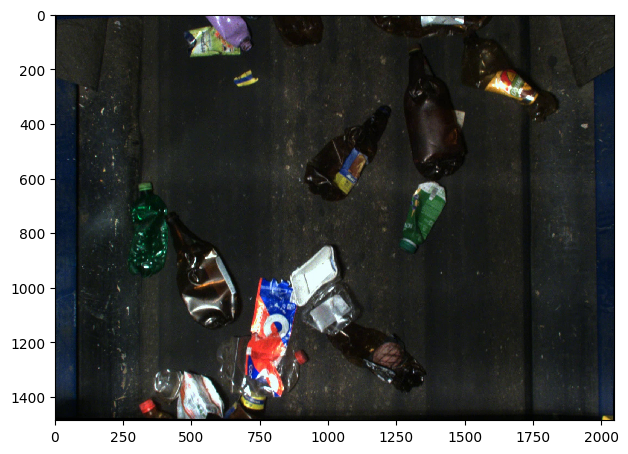

In [8]:
imshow('/kaggle/input/waste-detection/images/003082.jpg');
plt.show()

Можем заметить, что объекты могут накладываться друг на друга

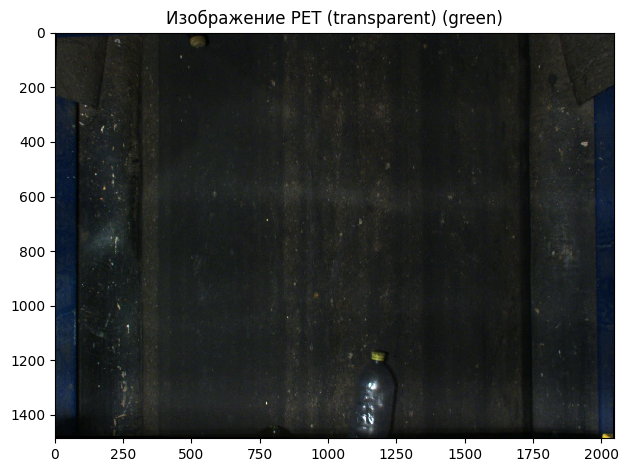

In [9]:
imshow('/kaggle/input/waste-detection/images/000027.jpg');
plt.title('Изображение PET (transparent) (green)')
plt.show()

In [10]:
train.loc[train['file_name'] == '003082.jpg']

,file_name,bbox,category_id
9399,003082.jpg,"[976.0, 1118.0, 396.0, 274.0]",2.0
9400,003082.jpg,"[841.0, 835.0, 283.0, 348.0]",14.0
9401,003082.jpg,"[408.0, 718.0, 273.0, 437.0]",2.0
9402,003082.jpg,"[268.0, 613.0, 149.0, 354.0]",1.0
9403,003082.jpg,"[1256.0, 609.0, 178.0, 267.0]",7.0
9404,003082.jpg,"[903.0, 321.0, 337.0, 372.0]",2.0
9405,003082.jpg,"[473.0, 39.0, 212.0, 127.0]",13.0
9406,003082.jpg,"[354.18, 1296.92, 100.67000000000002, 100.7100...",14.0
9407,003082.jpg,"[540.0, 0.0, 198.0, 139.0]",11.0
9408,003082.jpg,"[1486.0, 62.0, 354.0, 337.0]",2.0


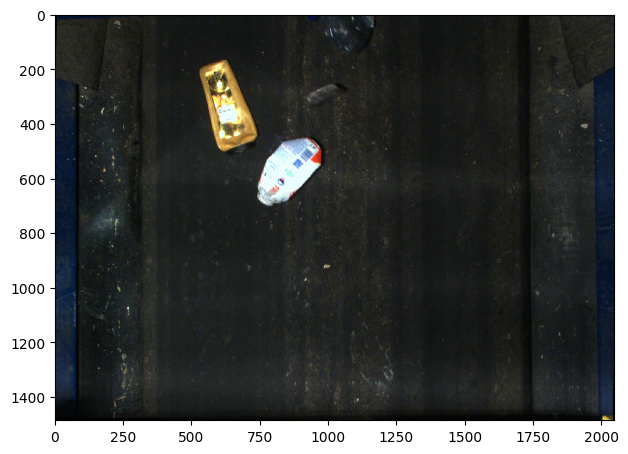

In [11]:
imshow('/kaggle/input/waste-detection/images/000124.jpg');
plt.show()

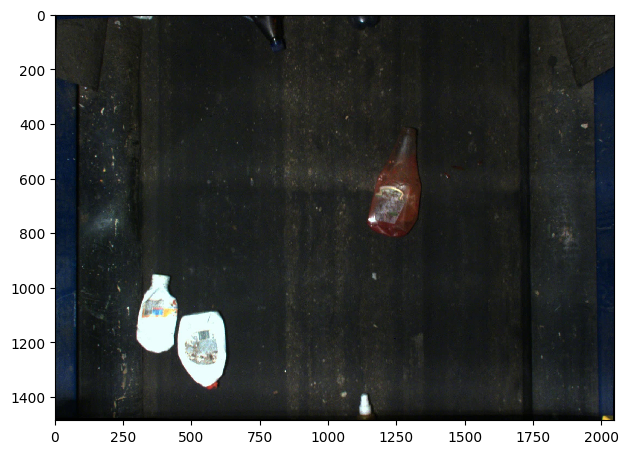

In [12]:
imshow('/kaggle/input/waste-detection/images/000158.jpg');
plt.show()

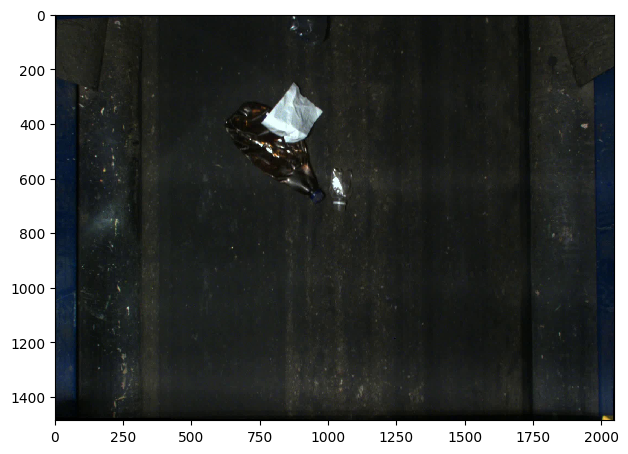

In [13]:
imshow('/kaggle/input/waste-detection/images/000001.jpg');
plt.show()

Пластиковые отходы можно отличить по форме и по цвету. Преобразуем категории так, чтобы начинались с 0

In [14]:
train['category_id'] = train['category_id'].apply(lambda x: x-1)

Преобразуем наши ограничительные рамки из строк в матрицы

In [15]:
def parse_bbox(x):
    if isinstance(x, str):
        return np.fromstring(x[1:-1], sep=',')
    else:
        return np.array([np.nan, np.nan, np.nan, np.nan]) 

In [16]:
bboxs = np.stack(train['bbox'].apply(parse_bbox).tolist())

In [17]:
bboxs

array([[        840,           0,         176,         124],
       [        612,         306,         383,         397],
       [     990.92,         551,         105,         186],
       ...,
       [        320,         631,         527,         218],
       [       1157,        1454,          65,          31],
       [        583,        1118,         281,         306]])

In [18]:
for i, columns in enumerate(['x','y', 'w', 'h']):
    train[columns] = bboxs[:,i]

train.drop(columns=['bbox'], inplace=True)
train['x_center'] = train['x'] + train['w'] / 2
train['y_center'] = train['y'] + train['h'] / 2

train = train[['file_name', 'x', 'y', 'w', 'h', 'x_center', 'y_center','category_id']]

In [19]:
train.head()

,file_name,x,y,w,h,x_center,y_center,category_id
0,000001.jpg,840.00,0.0,176.0,124.0,928.00,62.0,3.0
1,000001.jpg,612.00,306.0,383.0,397.0,803.50,504.5,1.0
2,000001.jpg,990.92,551.0,105.0,186.0,1043.42,644.0,3.0
3,000002.jpg,1000.00,614.0,98.0,178.0,1049.00,703.0,3.0
4,000002.jpg,605.00,358.0,402.0,409.0,806.00,562.5,1.0


Удалим пропуски

In [20]:
train = train.dropna()

In [21]:
train_index, val_index = train_test_split(train['file_name'].unique(),
                                         random_state=29112024)

Создадим каталоги train, valid с images, labels чтобы обучить нашу модель YOLO

In [22]:
source = 'train'

image_width = 2048  # ширина изображения
image_height = 1486  # высота изображения

for name, mini in tqdm.tqdm(train.groupby('file_name')):
    if name in val_index:
        path2save = 'valid/'
    else:
        path2save = 'train/'


    if not os.path.exists('labels/' + path2save):
        os.makedirs('labels/'+path2save)

    with open('labels/' + path2save+name+".txt",'w+') as f:
        row = mini[['category_id', 'x_center', 'y_center', 'w', 'h']].astype(float).\
                                                                  values

        row[:, 1] = row[:, 1] / image_width  # x_center нормализованный
        row[:, 2] = row[:, 2] / image_height  # y_center нормализованный
        row[:, 3] = row[:, 3] / image_width  # w нормализованный
        row[:, 4] = row[:, 4] / image_height  # h нормализованный

        
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")

    if not os.path.exists('images/{}'.format(path2save)):
        os.makedirs('images/{}'.format(path2save))

    sh.copy("../input/waste-detection/images/{}".format(name),'images/{}/{}'.format(path2save, name))

100%|██████████| 5884/5884 [01:21<00:00, 72.60it/s]


Создадим файл garbage.yaml для обучения

In [23]:
yaml_text = """---
train: /kaggle/working/images/train/
val: /kaggle/working/images/valid/
nc: 15
names: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]


"""

with open("garbage.yaml",'w') as f:
    f.write(yaml_text)

%cat garbage.yaml

---
train: /kaggle/working/images/train/
val: /kaggle/working/images/valid/
nc: 15
names: [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]




Загрузим преобученную модель на наших данных

In [31]:
model = YOLO('/kaggle/input/yolo11/pytorch/default/1/yolo11m.pt')

In [44]:
results = model.train(data="garbage.yaml", epochs=50, imgsz=1280, patience=5,batch=4,
                     augment=True, degress=180,
                     translate=1.0,mosaic=1.0, mixup=1.0,
                     copy_paste=1.0,
                     erasing=0.5, crop_fraction=0.6)

Так как у нас присутствует дисбаланс добавляем в модель аугментацию, чтобы модель лучше различала классы

In [ ]:
model_1 = YOLO('runs/detect/train3/weights/best.pt')

In [ ]:
test['file_name'] = test['file_name'].apply(lambda x: x[0:6])

In [ ]:
# Предполагаем, что `test` — это DataFrame с колонкой 'file_name'
for name, mini in tqdm.tqdm(test.groupby('file_name')):
    path2save = 'test/'
    if not os.path.exists('images/{}'.format(path2save)):
        os.makedirs('images/{}'.format(path2save))

    sh.copy("/kaggle/input/waste-detection/images/{}.jpg".format(name), 
            'images/{}/{}.jpg'.format(path2save, name))

In [ ]:
results_pred = model_new.predict('images/test', stream=True,conf=0.5 )

In [ ]:
# Список для хранения данных
#data = []

# Перебираем результаты
#for r in results:
    # Получаем изображения
   # img_name = r.path  # Получаем название изображения
   # boxes = r.boxes  # Получаем координаты рамок
   # xywh,conf,class_id = boxes.xywh.cpu().numpy(), boxes.conf.cpu().numpy(), boxes.cls.cpu().numpy()
   #data.append([img_name, xywh, conf,class_id])

# Создаем DataFrame
#df = pd.DataFrame(data, columns=['Image Name', 'xywh', 'conf','Class ID'])

In [ ]:
import concurrent.futures

def process_image(r):
    img_name = r.path
    boxes = r.boxes
    xywh, conf, class_id = boxes.xywh.cpu().numpy(), boxes.conf.cpu().numpy(), boxes.cls.cpu().numpy()
    return [img_name, xywh, conf, class_id]

data_2 = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results_data = list(executor.map(process_image, results_pred))

# Объединяем результаты в одном списке
data_2.extend(results_data)

# Создаем DataFrame
df_1 = pd.DataFrame(data_2, columns=['Image Name', 'xywh', 'conf', 'Class ID'])

In [ ]:
def create_combined_info(row):
    # Убедимся, что все три столбца имеют одинаковую длину
    n = len(row['Class ID'])
    combined_list = []  # Создаем список для хранения результатов

    for i in range(n):
        # Создаем подсписок и добавляем его в выходной список
        lst = [row['Class ID'][i] + 1, row['conf'][i]]
        lst.extend(row['xywh'][i])  # Добавляем координаты
        combined_list.append(lst)  # Добавляем подсписок в выходной список
        
    return combined_list  # Возвращаем полный список

In [ ]:
df_1['bb'] = df_1.apply(create_combined_info, axis=1)

In [ ]:
df_1['Image Name'] = df_1['Image Name'].apply(lambda x: x[28:])

In [ ]:
data_new = df_1[['Image Name', 'bb']]

In [ ]:
data_new = data_new.rename(columns={'Image Name': 'file_name', 'bb':'bbox'})

In [ ]:
def xminytop(row):
    return [
        [item[0], item[1], item[2] - item[4]/2, item[3]-item[5]/2, item[4], item[5]]
        for item in row
    ]

In [ ]:
data_new['bbox'] = data_new['bbox'].apply(lambda x: xminytop(x))

In [ ]:
data_new.to_csv('answer.csv', index=False)

## Вывод

Целью работы необходимо было обнаружить и классфицировать пластиковые отходы. В данных присутсвует 14 классов отходов с я вным дисбалансов классов. В ходе работы была выбрана модель YOLO  с аугментацией для того, чтобы модель лучше обучилась обнаруживать минорные классы. На тесте $MAP = 0.77$